## 6.10 Homework

The goal of this homework is to create a tree-based regression model for prediction apartment prices (column `'price'`).

In this homework we'll again use the New York City Airbnb Open Data dataset - the same one we used in homework 2 and 3.

You can take it from [Kaggle](https://www.kaggle.com/dgomonov/new-york-city-airbnb-open-data?select=AB_NYC_2019.csv)
or download from [here](https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AB_NYC_2019.csv)
if you don't want to sign up to Kaggle.

Let's load the data:

### INDEX
- [Question 1](#question-1)
- [Question 2](#question-2)
- [Question 3](#question-3)
- [Question 4](#question-4)
- [Question 5](#question-5)
- [Question 6](#question-6)

In [66]:
import os
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.tree import export_text
from sklearn.metrics import mean_squared_error


from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

import xgboost as xgb


%matplotlib inline

In [3]:
data = 'https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AB_NYC_2019.csv'
if not os.path.exists("AB_NYC_2019.csv"):
    !wget $data

In [4]:
columns = [
    'neighbourhood_group', 'room_type', 'latitude', 'longitude',
    'minimum_nights', 'number_of_reviews','reviews_per_month',
    'calculated_host_listings_count', 'availability_365',
    'price'
]

feat_list = [
    'neighbourhood_group', 'room_type', 'latitude', 'longitude',
    'minimum_nights', 'number_of_reviews','reviews_per_month',
    'calculated_host_listings_count', 'availability_365'
]

df = pd.read_csv('AB_NYC_2019.csv', usecols=columns)
df.reviews_per_month = df.reviews_per_month.fillna(0)

* Apply the log tranform to `price`
* Do train/validation/test split with 60%/20%/20% distribution. 
* Use the `train_test_split` function and set the `random_state` parameter to 1

In [5]:
df.price = np.log1p(df.price)
df.price

0        5.010635
1        5.420535
2        5.017280
3        4.499810
4        4.394449
           ...   
48890    4.262680
48891    3.713572
48892    4.753590
48893    4.025352
48894    4.510860
Name: price, Length: 48895, dtype: float64

In [17]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.price.values
y_val = df_val.price.values
y_test = df_test.price.values

Now, use `DictVectorizer` to turn train and validation into matrices:

In [7]:
dicts_train = df_train[feat_list].to_dict(orient='records')
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(dicts_train)

dicts_val = df_val[feat_list].to_dict(orient='records')
X_val = dv.transform(dicts_val)

In [8]:
dv.get_feature_names()

['availability_365',
 'calculated_host_listings_count',
 'latitude',
 'longitude',
 'minimum_nights',
 'neighbourhood_group=Bronx',
 'neighbourhood_group=Brooklyn',
 'neighbourhood_group=Manhattan',
 'neighbourhood_group=Queens',
 'neighbourhood_group=Staten Island',
 'number_of_reviews',
 'reviews_per_month',
 'room_type=Entire home/apt',
 'room_type=Private room',
 'room_type=Shared room']

## Question 1 <a class="anchor" id="question-1"></a>

Let's train a decision tree regressor to predict the price variable. 

* Train a model with `max_depth=1`

In [53]:
dt = DecisionTreeRegressor(max_depth=1)
dt.fit(X_train, y_train)
print(export_text(dt, feature_names=dv.get_feature_names()))

|--- room_type=Entire home/apt <= 0.50
|   |--- value: [4.29]
|--- room_type=Entire home/apt >  0.50
|   |--- value: [5.15]



Which feature is used for splitting the data?

* `room_type`
* `neighbourhood_group`
* `number_of_reviews`
* `reviews_per_month`

In [ ]:
print("[ANSWER-1] The feature used for split the data is: 'room_type'")

## Question 2 <a class="anchor" id="question-2"></a>

Train a random forest model with these parameters:

* `n_estimators=10`
* `random_state=1`
* `n_jobs=-1`  (optional - to make training faster)

In [28]:
X_train[0]

array([ 3.630000e+02,  1.000000e+00,  4.076434e+01, -7.392132e+01,
        4.000000e+00,  0.000000e+00,  0.000000e+00,  0.000000e+00,
        1.000000e+00,  0.000000e+00,  3.000000e+01,  3.200000e-01,
        1.000000e+00,  0.000000e+00,  0.000000e+00])

In [29]:
y_train[0]

4.709530201312334

In [24]:
y_val[0]

5.0106352940962555

In [34]:
rf = RandomForestRegressor(n_estimators=10, random_state=1, n_jobs=-1)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_val)
rmse_val = mean_squared_error(y_val, y_pred, squared=False)

What's the RMSE of this model on validation?

* 0.059
* 0.259
* 0.459
* 0.659

In [35]:
print(f"[ANSWER-2] The validation RMSE of this model is: {rmse_val}")

[ANSWER-2] The validation RMSE of this model is: 0.4598535778342608


## Question 3 <a class="anchor" id="question-3"></a>

Now let's experiment with the `n_estimators` parameter

* Try different values of this parameter from 10 to 200 with step 10
* Set `random_state` to `1`
* Evaluate the model on the validation dataset

In [36]:
scores = []

for n in range(10, 201, 10):
    rf = RandomForestRegressor(n_estimators=n, random_state=1)
    rf.fit(X_train, y_train)

    y_pred = rf.predict(X_val)
    rmse_val = mean_squared_error(y_val, y_pred, squared=False)
    
    scores.append((n, rmse_val))

In [37]:
df_scores = pd.DataFrame(scores, columns=['n_estimators', 'rmse'])

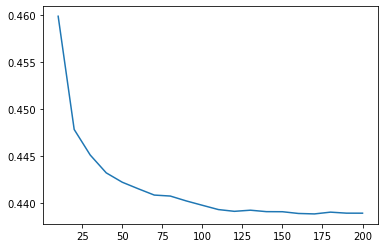

In [39]:
plt.plot(df_scores.n_estimators, df_scores.rmse)

After which value of `n_estimators` does RMSE stop improving?

- 10
- 50
- 70
- 120

In [40]:
print(f"[ANSWER-3] The RMSE stop improving after 120 estimators")

[ANSWER-3] The RMSE stop improving after 120 estimators


## Question 4 <a class="anchor" id="question-4"></a>

Let's select the best `max_depth`:

* Try different values of `max_depth`: `[10, 15, 20, 25]`
* For each of these values, try different values of `n_estimators` from 10 till 200 (with step 10)
* Fix the random seed: `random_state=1`

In [42]:
scores = []
for d in [10, 15, 20, 25]:
    for n in range(10, 201, 10):
        rf = RandomForestRegressor(n_estimators=n,
                                   max_depth=d,
                                   random_state=1)
        rf.fit(X_train, y_train)

        y_pred = rf.predict(X_val)
        rmse_val = mean_squared_error(y_val, y_pred, squared=False)

        scores.append((d, n, rmse_val))

In [43]:
columns = ['max_depth', 'n_estimators', 'rmse']
df_scores = pd.DataFrame(scores, columns=columns)

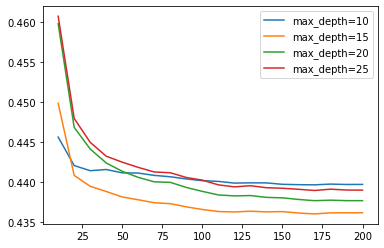

In [46]:
values = [10, 15, 20, 25]

for d in values:
    df_subset = df_scores[df_scores.max_depth == d]
    
    plt.plot(df_subset.n_estimators, df_subset.rmse,
             label='max_depth=%d' % d)

plt.legend()


What's the best `max_depth`:

* 10
* 15
* 20
* 25

Bonus question (not graded):

Will the answer be different if we change the seed for the model?

In [47]:
print(f"[ANSWER-4] The best 'max_depth' is: 15")

[ANSWER-4] The best 'max_depth' is: 15


## Question 5 <a class="anchor" id="question-5"></a>

We can extract feature importance information from tree-based models. 

At each step of the decision tree learning algorith, it finds the best split. 
When doint it, we can calculate "gain" - the reduction in impurity before and after the split. 
This gain is quite useful in understanding what are the imporatant features 
for tree-based models.

In Scikit-Learn, tree-based models contain this information in the `feature_importances_` field. 

For this homework question, we'll find the most important feature:

* Train the model with these parametes:
    * `n_estimators=10`,
    * `max_depth=20`,
    * `random_state=1`,
    * `n_jobs=-1` (optional)
* Get the feature importance information from this model

In [58]:
rf = RandomForestRegressor(n_estimators=10,
                           max_depth=20,
                           n_jobs=-1,
                           random_state=1)
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=20, n_estimators=10, n_jobs=-1, random_state=1)

In [63]:
max_value = None
max_feature = None

importance = rf.feature_importances_
for f,v in zip(dv.get_feature_names(), importance):
    print('Feature: %s, Score: %.5f' % (f,v))
    if max_value is None:
        max_value = v
    if max_value < v:
        max_value = v
        max_feature = f

Feature: availability_365, Score: 0.07657
Feature: calculated_host_listings_count, Score: 0.03026
Feature: latitude, Score: 0.15176
Feature: longitude, Score: 0.15348
Feature: minimum_nights, Score: 0.05317
Feature: neighbourhood_group=Bronx, Score: 0.00045
Feature: neighbourhood_group=Brooklyn, Score: 0.00111
Feature: neighbourhood_group=Manhattan, Score: 0.03404
Feature: neighbourhood_group=Queens, Score: 0.00103
Feature: neighbourhood_group=Staten Island, Score: 0.00008
Feature: number_of_reviews, Score: 0.04252
Feature: reviews_per_month, Score: 0.05459
Feature: room_type=Entire home/apt, Score: 0.39190
Feature: room_type=Private room, Score: 0.00488
Feature: room_type=Shared room, Score: 0.00416


What's the most important feature? 

* `neighbourhood_group=Manhattan`
* `room_type=Entire home/apt`	
* `longitude`
* `latitude`

In [65]:
print(f"[ANSWER-5] The most important feature is: {max_feature} ({max_value})")

[ANSWER-5] The most important feature is: room_type=Entire home/apt (0.3918980233885284)


## Question 6 <a class="anchor" id="question-6"></a>

Now let's train an XGBoost model! For this question, we'll tune the `eta` parameter

* Install XGBoost
* Create DMatrix for train and validation
* Create a watchlist
* Train a model with these parameters for 100 rounds:

```
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}
```

In [68]:
def parse_xgb_output(output):
    results = []

    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')

        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])

        results.append((it, train, val))
    
    columns = ['num_iter', 'train_rmse', 'val_rmse']
    df_results = pd.DataFrame(results, columns=columns)
    return df_results

In [69]:
scores = {}

features = dv.get_feature_names()
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

In [70]:
watchlist = [(dtrain, 'train'), (dval, 'val')]

In [76]:
%%capture output

xgb_params = {
    'eta': 0.01, 
    'max_depth': 6,
    'min_child_weight': 1,

    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'nthread': -1,

    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=100,
                  verbose_eval=5,
                  evals=watchlist)

In [77]:
key = 'eta=%s' % (xgb_params['eta'])
scores[key] = parse_xgb_output(output)
key

'eta=0.01'

In [78]:
scores

{'eta=0.3':     num_iter  train_rmse  val_rmse
 0          0     3.02752   3.02415
 1          5     0.67490   0.67752
 2         10     0.43912   0.44981
 3         15     0.42259   0.43827
 4         20     0.41716   0.43691
 5         25     0.41365   0.43621
 6         30     0.40712   0.43543
 7         35     0.40444   0.43510
 8         40     0.40103   0.43466
 9         45     0.39723   0.43371
 10        50     0.39446   0.43384
 11        55     0.39129   0.43378
 12        60     0.38743   0.43404
 13        65     0.38421   0.43450
 14        70     0.38117   0.43467
 15        75     0.37801   0.43489
 16        80     0.37668   0.43526
 17        85     0.37259   0.43537
 18        90     0.36998   0.43539
 19        95     0.36742   0.43579
 20        99     0.36478   0.43621,
 'eta=0.1':     num_iter  train_rmse  val_rmse
 0          0     3.87217   3.86889
 1          5     2.31905   2.31692
 2         10     1.41910   1.41786
 3         15     0.91299   0.91348
 4   

Now change `eta` first to `0.1` and then to `0.01`

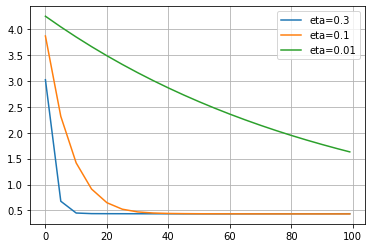

In [82]:
for eta, df_score in scores.items():
    plt.plot(df_score.num_iter, df_score.val_rmse, label=eta)
plt.legend()
plt.grid(True)


What's the best eta?

* 0.3
* 0.1
* 0.01

In [81]:
print(f"[ANSWER-6] The 'best' eta value is: 0.3")

[ANSWER-6] The 'best' eta value is: 0.3


## Submit the results


Submit your results here: https://forms.gle/wQgFkYE6CtdDed4w8

It's possible that your answers won't match exactly. If it's the case, select the closest one.


## Deadline


The deadline for submitting is 20 October 2021, 17:00 CET (Wednesday). After that, the form will be closed.

